1. Load in the data

In [63]:
import pandas as pd
import datetime as dt
import numpy as np
from dateutil import parser
def abs_parser(x):
    month = x.split('-')[0]
    year = int(x.split('-')[1])
    if year<=22:
        year = str(2000+year)
    else:
        year = str(1900+year)
    
    abs_parser =  dt.datetime.strptime(f'{month}-{year}', '%b-%Y').date()

    return abs_parser

election_parser = lambda x: dt.datetime.strptime(x, '%d/%m/%Y').date()
# Read the data as a dataframe
participation_df = pd.read_csv('data/ABS_participation.csv',header=1)
participation_df.rename( columns={'Unnamed: 0':'date'}, inplace=True )
participation_df.drop(participation_df.tail(5).index,inplace=True)
participation_df['date'] = participation_df['date'].apply(abs_parser)
participation_df.set_index('date', inplace=True)

unemployment_df = pd.read_csv('data/ABS_unemployment.csv',header=1)
unemployment_df.rename( columns={'Unnamed: 0':'date'}, inplace=True )
unemployment_df.drop(unemployment_df.tail(5).index,inplace=True)
unemployment_df['date'] = unemployment_df['date'].apply(abs_parser)
unemployment_df.set_index('date', inplace=True)

cpi_df = pd.read_csv('data/ABS_cpi.csv',header=1)
cpi_df.rename( columns={'Unnamed: 0':'date'}, inplace=True )
# cpi_df.drop(cpi_df.tail(5).index,inplace=True)
cpi_df['date'] = cpi_df['date'].apply(election_parser)
cpi_df.set_index('date', inplace=True)

gdp_df = pd.read_csv('data/ABS_gdp.csv',header=1)
gdp_df.rename( columns={'Unnamed: 0':'date'}, inplace=True )
# gdp_df.drop(gdp_df.tail(5).index,inplace=True)
gdp_df['date'] = gdp_df['date'].apply(election_parser)
gdp_df.set_index('date', inplace=True)

election_df = pd.read_csv('data/govt2pp_historical.csv')
election_df['date'] = election_df['date'].apply(election_parser)
election_df.set_index('date', inplace=True)


2. Clean the data

In [64]:
print(f"Entries in participation_df = {len(participation_df)}")
print(f"Entries in unemployment_df = {len(unemployment_df)}")
print(f"Entries in cpi_df = {len(cpi_df)}")
print(f"Entries in gdp_df = {len(gdp_df)}")

print(f"Entries in election_df = {len(election_df)}")


Entries in participation_df = 672
Entries in unemployment_df = 672
Entries in cpi_df = 293
Entries in gdp_df = 251
Entries in election_df = 22


In [65]:
# Functions for regression_df
## UNEMPLOYMENT FUNCTIONS
def unemployment(unemployment_df,election_date):
    return unemployment_df[unemployment_df.index<=election_date].iloc[-1]['Persons (%)']
def unemployment_adjusted_3year(unemployment_df,election_date):
    unemployment_vals = unemployment_df[unemployment_df.index<=election_date]['Persons (%)']
    current_unemployment = unemployment_vals[-1]
    if len(unemployment_vals)<12*3: 
        return current_unemployment - np.mean(unemployment_vals)
    else:
        return current_unemployment - np.mean(unemployment_vals[-12*3:])
def unemployment_delta(unemployment_df,election_date):
    [x1,x2] = unemployment_df[unemployment_df.index<=election_date].iloc[-2:]['Persons (%)']
    return x2-x1
def unemployment_delta_adjusted_3year(unemployment_df,election_date):
    unemployment_vals = unemployment_df[unemployment_df.index<=election_date]['Persons (%)']
    unemployment_deltas = unemployment_vals.diff()[1:] #.diff() returns the differences and .iloc[1:] removes the first entry which will be nan
    current_delta = unemployment_deltas[-1]
    if len(unemployment_deltas)<12*3: 
        return current_delta - np.mean(unemployment_deltas)
    else:
        return current_delta - np.mean(unemployment_deltas[-12*3:])

def long_unemployment_delta(unemployment_df,election_date):
    unemployment_vals = unemployment_df[unemployment_df.index<=election_date]['Persons (%)']
    if len(unemployment_vals)<=4:
        return (unemployment_vals[-1]-unemployment_vals[0])/(len(unemployment_vals)-1)
    else:
        return (unemployment_vals[-1]-unemployment_vals[-4])/(3)
def sqrt_unemployment_delta(unemployment_df,election_date): 
    val = long_unemployment_delta(unemployment_df,election_date)
    # return np.sign(val)*np.sqrt(abs(val))
    return np.sign(val)*(abs(val)**(1.5))


## PARTICIPATION FUNCTIONS
def participation(participation_df,election_date):
    return participation_df[participation_df.index<=election_date].iloc[-1]['Persons (%)']
def participation_adjusted_3year(participation_df,election_date):
    participation_vals = participation_df[participation_df.index<=election_date]['Persons (%)']
    current_participation = participation_vals[-1]
    if len(participation_vals)<12*3: 
        return current_participation - np.mean(participation_vals)
    else:
        return current_participation - np.mean(participation_vals[-12*3:])
def participation_delta(participation_df,election_date):
    [x1,x2] = participation_df[participation_df.index<=election_date].iloc[-2:]['Persons (%)']
    return x2-x1

## CPI FUNCTIONS
def cpi(cpi_df,election_date):
    return cpi_df[cpi_df.index<=election_date].iloc[-1]['National (%)']
def cpi_adjusted_3year(participation_df,election_date):
    cpi_vals = cpi_df[cpi_df.index<=election_date]['National (%)']
    current_cpi = cpi_vals[-1]
    if len(cpi_vals)<12*3: 
        return current_cpi - np.mean(cpi_vals)
    else:
        return current_cpi - np.mean(cpi_vals[-12*3:])

## GDP FUNCTIONS
def gdp(gdp_df,election_date):
    return gdp_df[gdp_df.index<=election_date].iloc[-1]['National (%)']
def gdp_adjusted_3year(gdp_df,election_date):
    gdp_vals = gdp_df[gdp_df.index<=election_date]['National (%)']
    current_gdp = gdp_vals[-1]
    if len(gdp_vals)<12*3: 
        return current_gdp - np.mean(gdp_vals)
    else:
        return current_gdp - np.mean(gdp_vals[-12*3:])
## GOVT RESULTS FUNCTIONS
def govt_tpp(election_df,election_date):
    return election_df.loc[election_date]['govt_tpp']
def govt_tpp_swing(election_df,election_date):
    return election_df.loc[election_date]['govt_tpp_swing']
def govt_seats(election_df,election_date):
    return election_df.loc[election_date]['govt_seats']
def govt_seats_change(election_df,election_date):
    return election_df.loc[election_date]['govt_seats_change']
def prev_govt_tpp_swing(election_df,election_date):
    if election_date == election_df.index[0]:
        return 0.043 #Swing in the 1966 election
    return election_df[election_df.index<election_date].iloc[-1]['govt_tpp_swing']
def prev_govt_tpp(election_df,election_date):
    if election_date == election_df.index[0]:
        return 0.526 #Swing in the 1966 election
    return election_df[election_df.index<election_date].iloc[-1]['govt_tpp']
def govt_party(election_df,election_date):
    party = election_df.loc[election_date]['govt_party']
    if party == 'LNP':
        return 1
    else:
        return -1

In [66]:
# Code to get election data

def generate_regression_df(election_df,*entries):
    '''A function that generates the regression dataframe used for analysis of data. Pass a list of entries to be included in the dataframe. An entry must be of the format
    (df, function) where df is the dataframe to be used and function is the function to be applied to the dataframe to generate the data to be included in the dataframe.'''
    columns = [entry[1].__name__ for entry in entries]
    columns.insert(0,'election_date')
    regression_df = pd.DataFrame(columns=columns)
    for index,election_date in enumerate(election_df.index):
        row_dict = {'election_date':election_date}
        for entry in entries:
            row_dict[entry[1].__name__] = entry[1](entry[0],election_date)

        row = pd.DataFrame(row_dict,index={index})
        regression_df = pd.concat([regression_df,row])
    convert_to_float32_dict = {column:np.float32 for column in regression_df.columns[1:]}
    convert_to_float32_dict['election_date'] = np.datetime64
    regression_df = regression_df.astype(convert_to_float32_dict)
    regression_df.set_index('election_date', inplace=True)
    return regression_df

entries = [
    (election_df,govt_tpp),
    (election_df,govt_tpp_swing),
    (election_df,govt_seats),
    (election_df,govt_seats_change),
    (election_df,prev_govt_tpp_swing),
    (election_df,prev_govt_tpp),
    (election_df,govt_party), 
    (unemployment_df,unemployment),
    (unemployment_df,unemployment_adjusted_3year),
    (unemployment_df,unemployment_delta),
    (unemployment_df,unemployment_delta_adjusted_3year),
    (unemployment_df,long_unemployment_delta),
    (unemployment_df,sqrt_unemployment_delta),
    (participation_df,participation),
    (participation_df,participation_adjusted_3year),
    (participation_df,participation_delta),
    (cpi_df,cpi),
    (cpi_df,cpi_adjusted_3year),
    (gdp_df,gdp),
    (gdp_df,gdp_adjusted_3year)
    ]

regression_df = generate_regression_df(election_df,*entries)

In [67]:
# normalise regression_df
regression_df = (regression_df - regression_df.mean())/regression_df.std()

In [68]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
# with sklearn
ignores = ['govt_tpp','govt_tpp_swing','govt_seats','govt_seats_change']
# removes = ['prev_govt_tpp_swing','unemployment_delta_adjusted_3year','gdp_adjusted_3year','unemployment_delta','cpi_adjusted_3year','participation','unemployment']
removes = []

regress_list = [fnc[1].__name__ for fnc in entries if fnc[1].__name__ not in (ignores+removes)]

x = regression_df[regress_list]
y = regression_df['govt_tpp_swing']

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 -6.090945e-07
Coefficients: 
 [-0.7087107  -0.08426005  0.21337242  0.12700786 -0.4295753  -2.5403965
  2.525327   -3.1935642   3.601677   -1.0065913  -0.41704422  0.41994482
 -1.2410434   0.9341809  -2.0347092   1.7402939 ]
                            OLS Regression Results                            
Dep. Variable:         govt_tpp_swing   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                 -0.734
Method:                 Least Squares   F-statistic:                    0.4445
Date:                Tue, 01 Nov 2022   Prob (F-statistic):              0.901
Time:                        18:08:11   Log-Likelihood:                -20.973
No. Observations:                  22   AIC:                             75.95
Df Residuals:                       5   BIC:                             94.49
Df Model:                          16                                         
Covariance Type:            nonrobust              

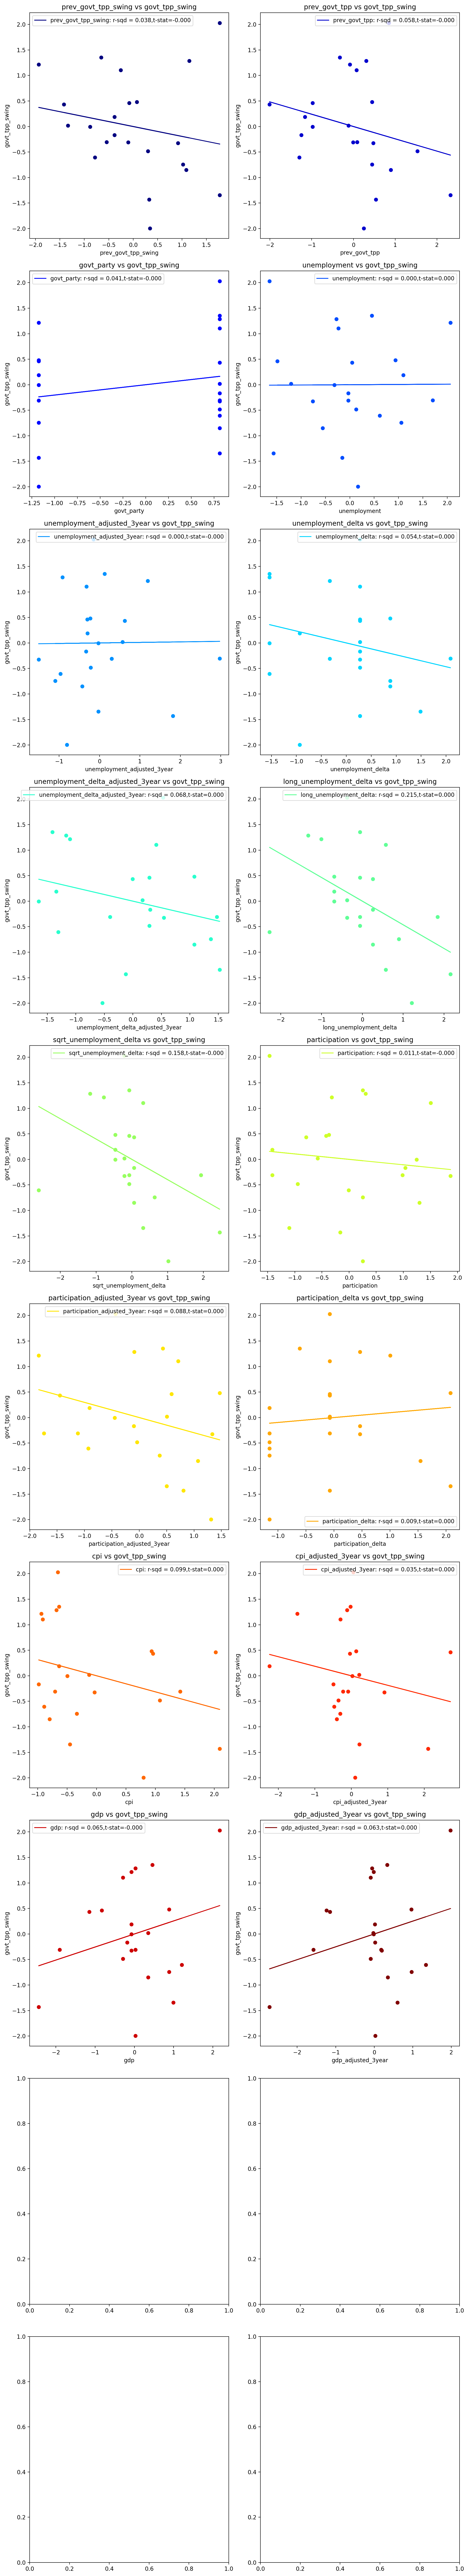

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, ttest_ind
import random
def generate_colormap(y_names):
    colors = plt.cm.jet(np.linspace(0,1,len(y_names)))
    return dict(zip(y_names,colors))

def plot_regression(x:pd.Series,y:pd.Series,ax,index,color=None):
    if color is None: color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    the_shape = ax.shape
    ax_index = ax[index//the_shape[1],index%the_shape[1]]
    ax_index.scatter(x,y,color=color)
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    t = ttest_ind(x,y)
    ax_index.plot(x, intercept + slope*x, color=color, label=f'{x.name}: r-sqd = {r_value**2:.3f},t-stat={t.statistic:.3f}')
    ax_index.set_xlabel(x.name)
    ax_index.set_ylabel(y.name)
    ax_index.set_title(f'{x.name} vs {y.name}')
    ax_index.legend()
    return index+1,p_value,r_value
non_plots = ['govt_tpp','govt_tpp_swing','govt_seats','govt_seats_change']

fig, ax = plt.subplots(-(len(regression_df.columns)//-2),2,figsize=(12,4*(len(regression_df.columns)-len(non_plots))),dpi=200)
index = 0
ynames = [column for column in regression_df.columns if column not in non_plots]
colourmap = generate_colormap(ynames)
p_values = {}
for column in ynames:
    index,p,r = plot_regression(regression_df[column],regression_df['govt_tpp_swing'],ax,index,color=colourmap[column])
    #index = plot_regression(regression_df[column],regression_df['govt_tpp'],ax,index,color=colourmap[column])
    p_values[column] = (p,r**2)
fig.tight_layout()
plt.show()

In [70]:
print(sorted(p_values.items(),key=lambda x: x[1][1],reverse=True))

[('long_unemployment_delta', (0.02981033014551074, 0.2148317808300944)), ('sqrt_unemployment_delta', (0.06688041196362078, 0.1580915627531058)), ('cpi', (0.152972269949076, 0.09938607952886508)), ('participation_adjusted_3year', (0.17890033827484386, 0.08844596662545884)), ('unemployment_delta_adjusted_3year', (0.2425443413152283, 0.06761061522768168)), ('gdp', (0.2507340823228713, 0.06538423854488322)), ('gdp_adjusted_3year', (0.2585557896508267, 0.06333497608425882)), ('prev_govt_tpp', (0.2794817677809098, 0.05819078481899314)), ('unemployment_delta', (0.2964111914845726, 0.05435336861330286)), ('govt_party', (0.3660218815978036, 0.04102127573017345)), ('prev_govt_tpp_swing', (0.3876938813452494, 0.037526816568262775)), ('cpi_adjusted_3year', (0.40546844429154083, 0.03485346754660885)), ('participation', (0.6365712638008516, 0.011379668492283427)), ('participation_delta', (0.6701587753043825, 0.009257057854094355)), ('unemployment_adjusted_3year', (0.9633076960095517, 0.0001084864159

In [ ]:
def optimise_adjustment(abs_df, election_df)->function:
    '''
    Takes a given set of data to analyse against election data
    1. Create a function of the form entered into the regression data above
    2. Performs above code for given function and stores r_sqd.
    3. Iterates with pertebation until r_sqd maximised

    '''
    def function_generator(adjust:bool, delta:bool)-> function:
        func 

        return func
    return optimised_function